In [1]:
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, mean_absolute_error
from scikitplot.metrics import plot_roc

In [192]:
df = pd.read_csv('C:/Users/User/Downloads/archive/dataset.csv')

In [193]:
df = df.groupby('app_name').apply(lambda x: x.head(150)).reset_index(drop=True)

In [194]:
df.shape

(714598, 5)

In [195]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,490390,神明的一天世界-God's One Day World,I haven't completed any ending of this game (i...,1,1
1,490390,神明的一天世界-God's One Day World,It looks like a galgame. but indeed it's a att...,1,1
2,490390,神明的一天世界-God's One Day World,+ This game is a really nice VN. + Cool story ...,1,1
3,490390,神明的一天世界-God's One Day World,This game is a really nice VN. The story is w...,1,0
4,490390,神明的一天世界-God's One Day World,Thank you for adding the english translation. ...,1,0


<Axes: title={'center': 'Rating Distribution'}>

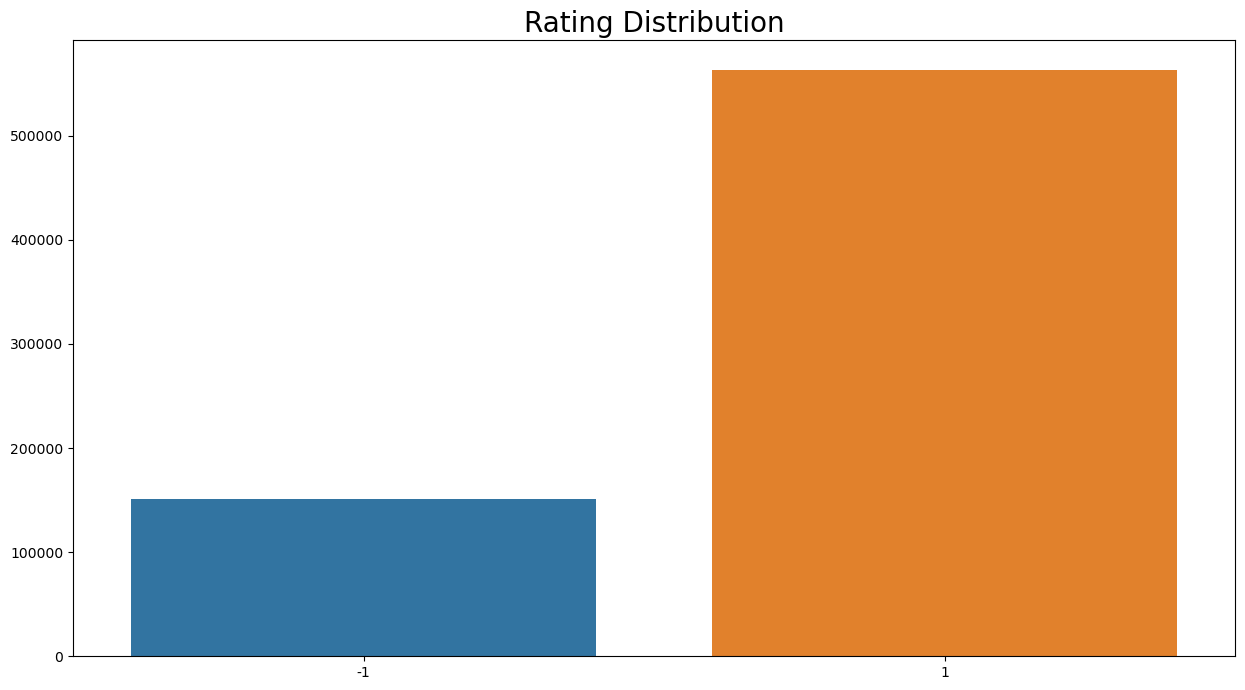

In [196]:
plt.figure(figsize=(15, 8))
plt.title('Rating Distribution', fontsize=20)

train_distribution = df['review_score'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values)

In [232]:
positive_reviews = df[df['review_score'] == 1]
negative_reviews = df[df['review_score'] == -1]

In [249]:
negative_reviews.shape

(151178, 6)

In [250]:
positive_reviews_needed = int(negative_reviews.shape[0] / (2/3))

In [251]:
positive_reviews_sample = positive_reviews.sample(positive_reviews_needed, random_state=42)

In [252]:
balanced_data = pd.concat([positive_reviews_sample, negative_reviews])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

<Axes: title={'center': 'Rating Distribution'}>

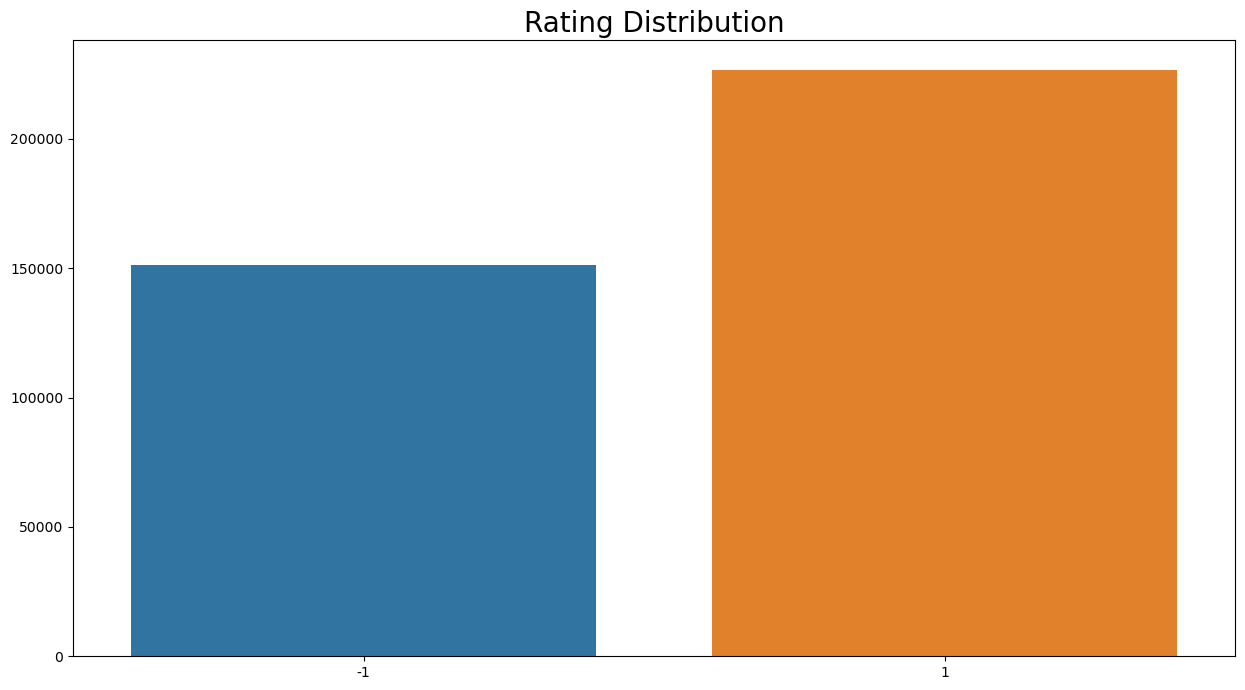

In [275]:
plt.figure(figsize=(15, 8))
plt.title('Rating Distribution', fontsize=20)

train_distribution = balanced_data['review_score'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values)

In [253]:
# Label encode ratings
balanced_data["rating_encoded"] = balanced_data['review_score'].apply(lambda x: 1 if x == 1 else 0)

In [276]:
balanced_data.head()

,app_id,app_name,review_text,review_score,review_votes,rating_encoded
0,506140,Shop Heroes,Considering this is my first time playing a MM...,1,0,1
1,275670,Space Run,Recommended: While the price might be a litt...,1,0,1
2,348380,The Interview,I don't recommend buying this game simply beca...,-1,1,0
3,34420,XIII Century,You probally wondor 'What in the world is this...,1,0,1
4,37220,Cooking Dash,fun to play enjoyed it very much!!!!,1,0,1


In [255]:
from sklearn.model_selection import train_test_split

train_idx, val_idx, _, _ = train_test_split(
    balanced_data.index, balanced_data.rating_encoded, 
    test_size=0.2, stratify=balanced_data.rating_encoded,
    random_state=768
)

In [256]:
train_new_df = balanced_data.iloc[train_idx].reset_index(drop=True)
val_df = balanced_data.iloc[val_idx].reset_index(drop=True)


train_new_df.shape, val_df.shape

((302356, 6), (75589, 6))

<Axes: title={'center': 'Validation Ratings Distribution'}>

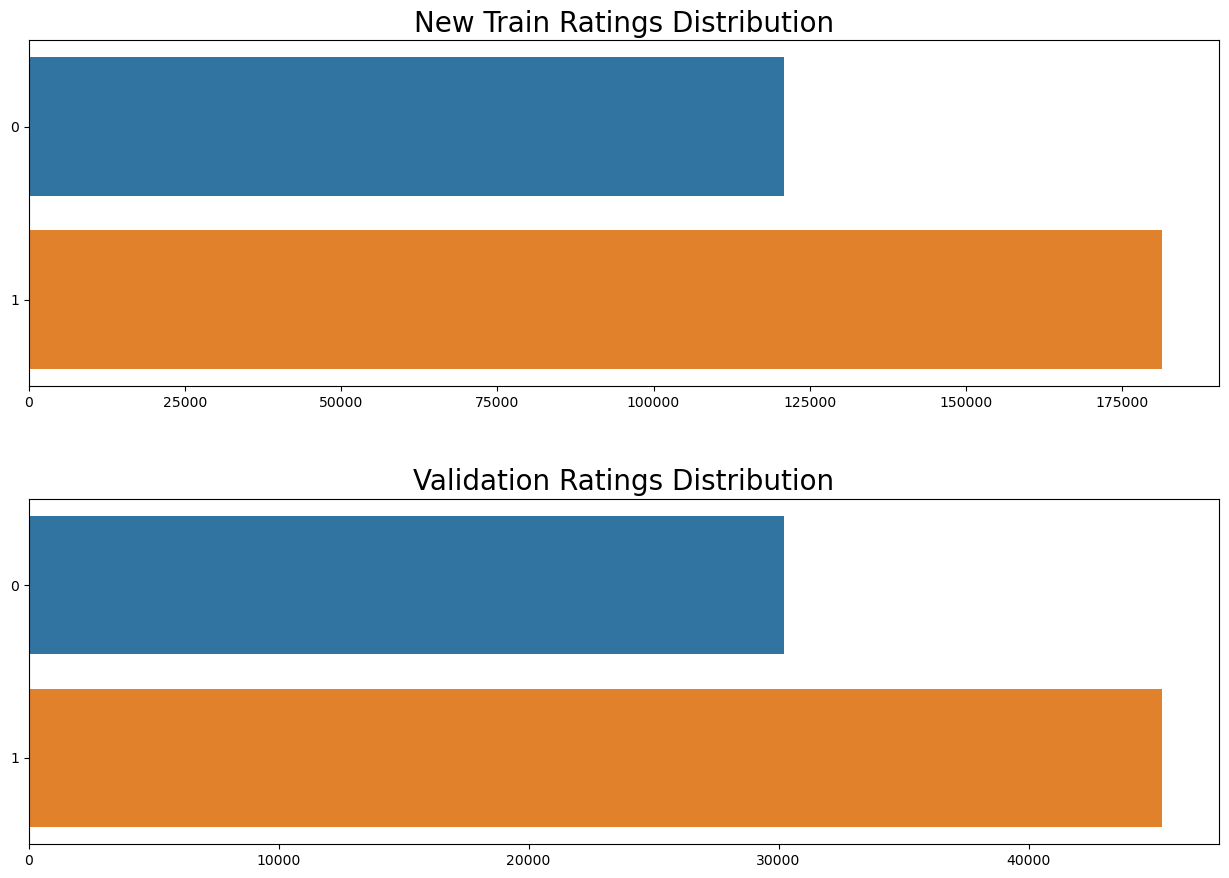

In [257]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))


fig.tight_layout(pad=6.0)


ax1.set_title('New Train Ratings Distribution', fontsize=20)
train_new_distribution = train_new_df['rating_encoded'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)

ax2.set_title('Validation Ratings Distribution', fontsize=20)
val_distribution = val_df['rating_encoded'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2)

In [201]:
def text_preprocessor(text):
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    import re
    
    text = str(text)
    lemmatizer = WordNetLemmatizer()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove non-word characters, convert to lowercase
    words = [word.lower() for word in words if word.isalpha()]

    # Lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a string
    preprocessed_text = ' '.join(words)
    
    return preprocessed_text

In [281]:
review_text = "GARBAGE!!!Inexcusable EA!!!Refunding ASAP...until these issues get fixed & price discounted, don't waste your time on this game!"
preprocessed_review = text_preprocessor(review_text)
preprocessed_review

'garbage inexcusable ea refunding asap until these issue get fixed price discounted do waste your time on this game'

In [258]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_new_df['review_text'].apply(text_preprocessor))

X_train = tokenizer.texts_to_sequences(train_new_df['review_text'].apply(text_preprocessor))
X_val = tokenizer.texts_to_sequences(val_df['review_text'].apply(text_preprocessor))

# Padding
max_length = 150
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')

y_train = train_new_df['rating_encoded'].values
y_val = val_df['rating_encoded'].values


In [259]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential([
    Embedding(10000, 64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [260]:
# Коллбэки
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

CALLBACKS = [early_stopping_callback, reduce_lr_callback]

In [261]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=CALLBACKS,
    batch_size=64,
    verbose=1
)

Epoch 1/10
4725/4725 [==============================] - 231s 48ms/step - loss: 0.4006 - accuracy: 0.8187 - val_loss: 0.3473 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 2/10
4725/4725 [==============================] - 227s 48ms/step - loss: 0.3319 - accuracy: 0.8541 - val_loss: 0.3316 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 3/10
4725/4725 [==============================] - 228s 48ms/step - loss: 0.3024 - accuracy: 0.8673 - val_loss: 0.3249 - val_accuracy: 0.8539 - lr: 0.0010
Epoch 4/10
4725/4725 [==============================] - 223s 47ms/step - loss: 0.2790 - accuracy: 0.8778 - val_loss: 0.3291 - val_accuracy: 0.8539 - lr: 0.0010
Epoch 5/10
4724/4725 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.8884
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4725/4725 [==============================] - 227s 48ms/step - loss: 0.2556 - accuracy: 0.8884 - val_loss: 0.3397 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 6/10
4725/4725 [==============

In [262]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Accuracy: {accuracy:.2f}")

2363/2363 [==============================] - 49s 21ms/step - loss: 0.3249 - accuracy: 0.8539
Accuracy: 0.85


In [207]:
val_probabilities = model.predict(X_val, verbose=1)
val_predictions = (val_probabilities > 0.5).astype(int)

4467/4467 [==============================] - 90s 20ms/step


In [280]:
val_probabilities.shape

(142920, 1)

In [263]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend()

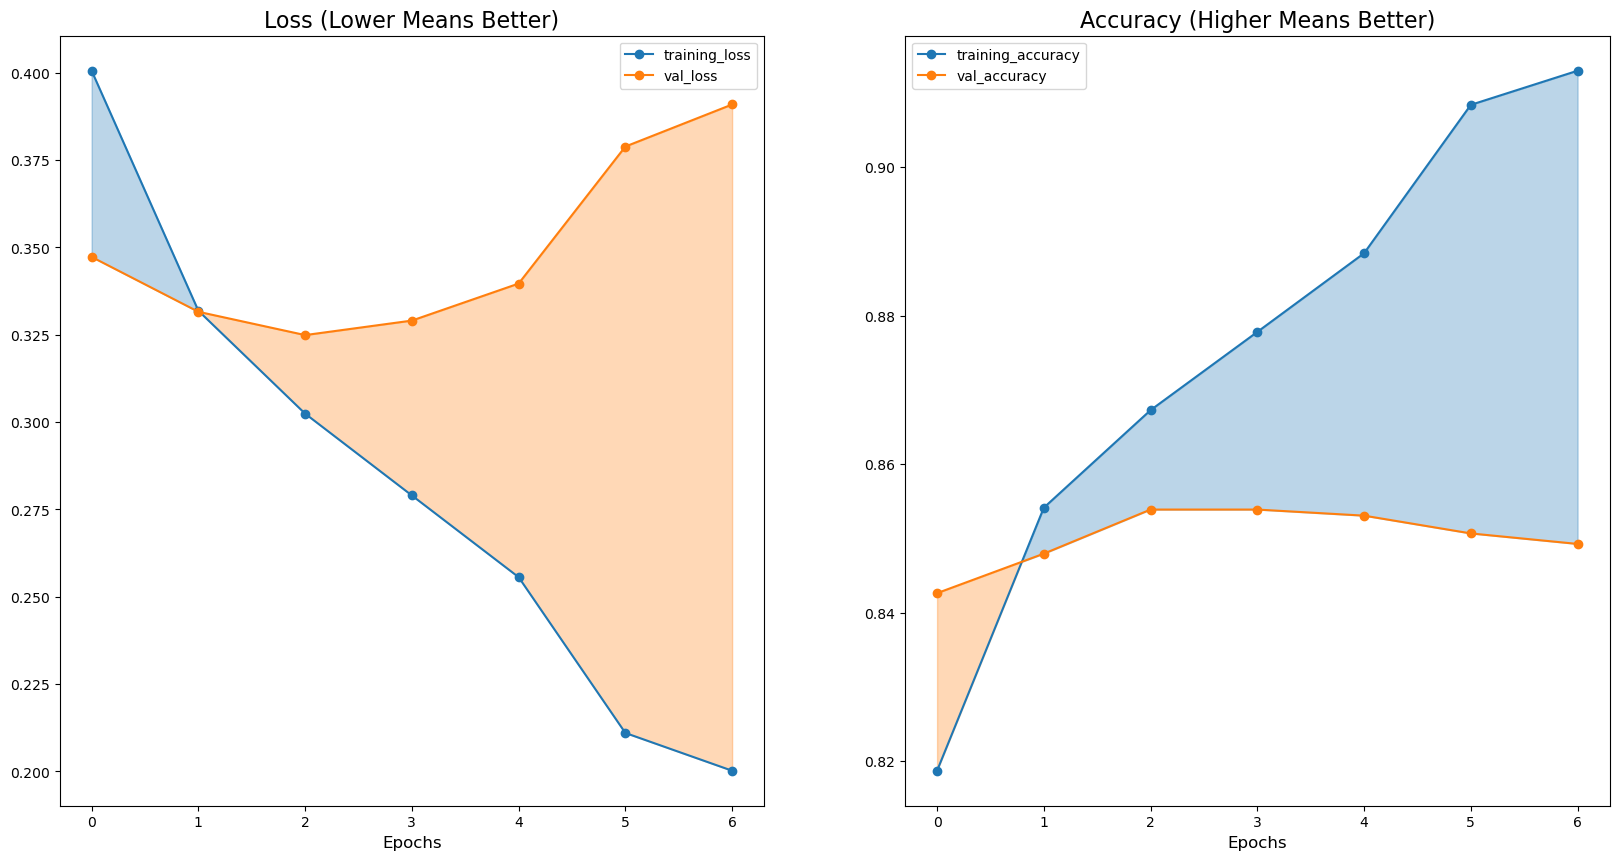

In [264]:
import numpy as np
import matplotlib.pyplot as plt

plot_training_curves(history)

In [274]:
review_text = "If you liked Fallen Order you’ll love this game, but the performance issues are obvious and frustrating at times due to how good this game actually is.Once they’re fixed there’s no doubt this game will be regarded as one of the best Star Wars games out there."
preprocessed_review = text_preprocessor(review_text)

sequence = tokenizer.texts_to_sequences([preprocessed_review])

padded_sequence = pad_sequences(sequence, maxlen=max_length)

prediction = model.predict(padded_sequence)

if prediction >= 0.5:
    print("The predicted sentiment is positive.")
else:
    print("The predicted sentiment is negative.")

The predicted sentiment is positive.


In [273]:
review_text = "GARBAGE!!!Inexcusable EA!!!Refunding ASAP...until these issues get fixed & price discounted, don't waste your time on this game!"
preprocessed_review = text_preprocessor(review_text)

sequence = tokenizer.texts_to_sequences([preprocessed_review])

padded_sequence = pad_sequences(sequence, maxlen=max_length)

prediction = model.predict(padded_sequence)

if prediction[0][0] > 0.5:
    print("The predicted sentiment is positive.")
else:
    print("The predicted sentiment is negative.")

The predicted sentiment is negative.
